# Classify snow-covered area (SCA) in Sentinel-2, Landsat 8/9, and PlanetScope imagery: full pipelines

Rainey Aberle

Department of Geosciences, Boise State University

2022

### Requirements:
- Area of Interest (AOI) shapefile: where snow will be classified in all available images. 
- Google Earth Engine (GEE) account: used to pull DEM over the AOI. Sign up for a free account [here](https://earthengine.google.com/new_signup/). 
- Digital elevation model (DEM) (_optional_): used to extract elevations over the AOI and for each snowline. If no DEM is provided, the ASTER Global DEM will be loaded through GEE. 

### Outline:
__0. Setup__ paths in directory, file locations, authenticate GEE - _modify this section!_

__1. Sentinel-2 Top of Atmosphere (TOA) imagery:__ full pipeline

__2. Sentinel-2 Surface Reflectance (SR) imagery:__ full pipeline

__3. Landsat 8/9 Surface Reflectance (SR) imagery:__ full pipeline

__4. PlanetScope Surface Reflectance (SR) imagery:__ full pipeline

-------


### 0. Setup

#### Define paths in directory and desired settings. 
Modify lines located within the following:

`#### MODIFY HERE ####`  

`#####################`

In [1]:
##### MODIFY HERE #####

# -----Paths in directory
site_name = 'RGI60-02.14297'
# path to snow-cover-mapping/ - Make sure you include a "/" at the end
base_path = '/Users/icebergs/snow-cover-mapping/snow-cover-mapping/'
# path to AOI including the name of the shapefile
AOI_path = base_path + '../study-sites/' + site_name + '/AOIs/'
# AOI file name
AOI_fn =  'RGI60-02.14297.shp'
# path to DEM including the name of the tif file
# Note: set DEM_path==None and DEM_fn=None if you want to use the ASTER GDEM via Google Earth Engine
DEM_path = None
# DEM file name
DEM_fn = None
# path for output images
out_path = base_path + '../study-sites/' + site_name + '/imagery/'
# path to PlanetScope images
# Note: set PS_im_path=None if not using PlanetScope
PS_im_path = out_path + 'PlanetScope/raw_images/'
# path for output figures
figures_out_path = base_path + '../study-sites/' + site_name + '/figures/'

# -----Define image search filters
date_start = '2016-05-01'
date_end = '2023-01-01'
month_start = 5
month_end = 11
cloud_cover_max = 70

# -----Determine whether to mask clouds using the respective cloud masking data products
# NOTE: Cloud mask products anecdotally are less accurate over glacierized/snow-covered surfaces. 
# If the cloud masks are consistently masking large regions or your study site, I suggest setting mask_clouds = False
mask_clouds = False

# -----Determine clipping & plotting settings
plot_results = True # = True to plot figures of results for each image where applicable
skip_clipped = False # = True to skip images where bands appear "clipped", i.e. max(blue) < 0.8
crop_to_AOI = True # = True to crop images to AOI before calculating SCA
save_outputs = True # = True to save SCAs and snowlines to file
save_figures = True # = True to save SCA output figures to file

#######################

# -----Import packages
import xarray as xr
import os
import numpy as np
import glob
from matplotlib import pyplot as plt, dates
import matplotlib
import rasterio as rio
import geopandas as gpd
import pandas as pd
import sys
import ee
import geedim as gd
import pickle
import time
from tqdm.auto import tqdm

# -----Set paths for output files
PS_im_masked_path = out_path + 'PlanetScope/masked/'
PS_im_mosaics_path = out_path + 'PlanetScope/mosaics/'
im_classified_path = out_path + 'classified/'
snowlines_path = out_path + 'snowlines/'

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
import pipeline_utils as f

# -----Load dataset dictionary
with open(base_path + 'inputs-outputs/datasets_characteristics.pkl', 'rb') as fn:
    dataset_dict = pickle.load(fn)

#### Authenticate and initialize Google Earth Engine (GEE). 

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back into the space below this cell when prompted. 

In [2]:
try:
    gd.Initialize()
except: 
    gd.Authenticate()
    gd.Initialize()

#### Load AOI and DEM

Optimal UTM CRS = EPSG:32610


Downloading:   0%|          | 0.00/15.9k [00:00<?, ?iB/s]

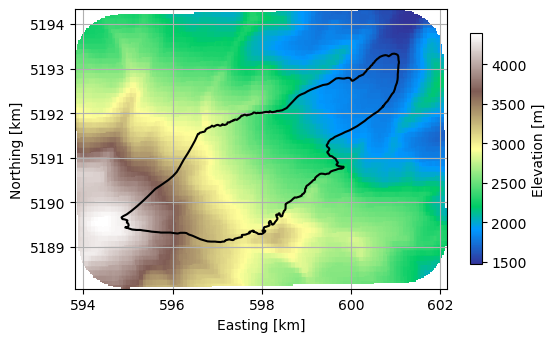

In [3]:
# -----Load AOI as gpd.GeoDataFrame
AOI = gpd.read_file(AOI_path + AOI_fn)
# reproject the AOI to WGS to solve for the optimal UTM zone
AOI_WGS = AOI.to_crs('EPSG:4326')
AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                    AOI_WGS.geometry[0].centroid.xy[1][0]]
# grab the optimal UTM zone EPSG code
epsg_UTM = f.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])
print('Optimal UTM CRS = EPSG:' + str(epsg_UTM))

# -----Load DEM as Xarray DataSet
if DEM_fn==None:
    # query GEE for DEM
    DEM, AOI_UTM = f.query_GEE_for_DEM(AOI)
else:
    # reproject AOI to UTM
    AOI_UTM = AOI.to_crs('EPSG:'+str(epsg_UTM))
    # load DEM as xarray DataSet
    DEM = xr.open_dataset(DEM_path + DEM_fn)
    DEM = DEM.rename({'band_data': 'elevation'})
    # reproject the DEM to the optimal UTM zone
    DEM = DEM.rio.reproject('EPSG:'+str(epsg_UTM))
    
# -----Plot
fig, ax = plt.subplots(1, 1, figsize=(6,6))
dem_im = ax.imshow(DEM.elevation.data[0], cmap='terrain', 
          extent=(np.min(DEM.x.data)/1e3, np.max(DEM.x.data)/1e3, np.min(DEM.y.data)/1e3, np.max(DEM.y.data)/1e3))
ax.plot([x/1e3 for x in AOI_UTM.geometry[0].exterior.coords.xy[0]],
        [y/1e3 for y in AOI_UTM.geometry[0].exterior.coords.xy[1]], '-k')
ax.grid()
ax.set_xlabel('Easting [km]')
ax.set_ylabel('Northing [km]')
fig.colorbar(dem_im, ax=ax, shrink=0.5, label='Elevation [m]')
plt.show()

## 1. Sentinel-2 TOA imagery

In [ ]:
print('Sentinel-2 TOA')
print('----------')

# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/S2_TOA_classifier_all_sites.sav'
clf = pickle.load(open(clf_fn, 'rb'))
feature_cols_fn = base_path+'inputs-outputs/S2_TOA_feature_cols.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# -----Query GEE for imagery
dataset = 'Sentinel2_TOA'
im_list = f.query_GEE_for_Sentinel2(dataset, dataset_dict, site_name, AOI_UTM, 
                                    date_start, date_end, month_start, month_end, 
                                    cloud_cover_max, mask_clouds)
im_list_size = im_list.size().getInfo()

# -----Loop through images
if im_list_size==0: # check that images were found
    print('No images found to classify, quitting...')
else:
    
    for i in tqdm(range(0, im_list_size)):
        
        # -----Select image by index
        im = ee.Image(ee.List(im_list).get(i))
        # get image time
        im_date = im.date().format(None, 'GMT').getInfo()
        print(' ')
        print(str(i+1)+'/'+str(im_list_size))
        print(im_date)
        
        # -----Convert ee.Image to xarray.Dataset
        # only convert if either classified image or snowline do not exist (converting to xarray.Dataset is time consuming)
        im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
        snowline_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline.pkl'
        if (os.path.exists(im_classified_path + im_classified_fn)==False) | (os.path.exists(snowlines_path + snowline_fn)==False):
            res = dataset_dict[dataset]['resolution_m']
            im_xr = im.wx.to_xarray(scale=res, crs='EPSG:4326')
            # reproject to UTM CRS
            im_xr_UTM = im_xr.rio.reproject('EPSG:'+epsg_UTM)
            # replace no data values with NaN and account for image scalar
            bands = [band for band in dataset_dict[dataset]['bands'] if 'QA' not in band]
            for band in bands:
                im_xr_UTM[band] = xr.where(im_xr_UTM[band] != dataset_dict[dataset]['no_data_value'],
                                           im_xr_UTM[band] / dataset_dict[dataset]['im_scalar'], np.nan)
            # add NDSI band
            im_xr_UTM['NDSI'] = ((im_xr_UTM[dataset_dict[dataset]['NDSI'][0]] - im_xr_UTM[dataset_dict[dataset]['NDSI'][1]]) 
                                 / (im_xr_UTM[dataset_dict[dataset]['NDSI'][0]] + im_xr_UTM[dataset_dict[dataset]['NDSI'][1]]))
                
        # -----Classify image
        # check if classified image already exists in file
        if os.path.exists(im_classified_path + im_classified_fn):
            print('Classified image already exists in file, continuing...')
            # check if snowline already exists in file
            if os.path.exists(snowlines_path + snowline_fn):
                print('Snowline already exists in file, continuing...')
                continue # no need to load classified image if snowline already exists
            else:
                im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
        else:  
            # classify image
            im_classified = f.classify_image(im_xr_UTM, clf, feature_cols, crop_to_AOI, 
                                             AOI_UTM, dataset, dataset_dict, site_name, 
                                             im_classified_fn, im_classified_path)
            if type(im_classified)==str: # skip if error in classification
                continue
        
        # -----Delineate snowline(s)
        # check if snowline already exists in file
        if os.path.exists(snowlines_path + snowline_fn):
            print('Snowline already exists in file, continuing...')
            continue # no need to load snowline if it already exists
        else:
            plot_results = True
            # create directory for figures if it doesn't already exist
            if (os.path.exists(figures_out_path)==False) & (plot_results==True):
                os.mkdir(figure_out_path)
                print('Created directory for output figures: '+figures_out_path)
            snowline_df = f.delineate_im_snowline(im_xr_UTM, im_classified, site_name, AOI_UTM, DEM, 
                                                  dataset_dict, dataset, im_date, snowline_fn, 
                                                  snowlines_path, figures_out_path, plot_results)
            plt.show()
            print('Median snowline elevation: ' + str(snowline_df['snowlines_elevs_median'][0]) + ' m')

## 2. Sentinel-2 SR imagery

In [ ]:
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/S2_SR_classifier_all_sites.sav'
clf = pickle.load(open(clf_fn, 'rb'))
feature_cols_fn = base_path+'inputs-outputs/S2_SR_feature_cols.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# -----Query GEE for imagery
dataset = 'Sentinel2_SR'
im_list = f.query_GEE_for_Sentinel2(dataset, dataset_dict, site_name, AOI_UTM, 
                                    date_start, date_end, month_start, month_end, 
                                    cloud_cover_max, mask_clouds)
im_list_size = im_list.size().getInfo()

# -----Loop through images
if im_list_size==0: # check that images were found
    print('No images found to classify, quiting...')
else:
    
    for i in tqdm(range(0, im_list_size)):
        
        # -----Select image by index
        im = ee.Image(ee.List(im_list).get(i))
        # get image time
        im_date = im.date().format(None, 'GMT').getInfo()
        print(' ')
        print(str(i+1)+'/'+str(im_list_size))
        print(im_date)
        
        # -----Convert ee.Image to xarray.Dataset
        # only convert if either classified image or snowline do not exist (converting to xarray.Dataset is time consuming)
        im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
        snowline_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline.pkl'
        if (os.path.exists(im_classified_path + im_classified_fn)==False) | (os.path.exists(snowlines_path + snowline_fn)==False):
            res = dataset_dict[dataset]['resolution_m']
            im_xr = im.wx.to_xarray(scale=res, crs='EPSG:4326')
            # reproject to UTM CRS
            im_xr_UTM = im_xr.rio.reproject('EPSG:'+epsg_UTM)
            # replace no data values with NaN and account for image scalar
            bands = [band for band in dataset_dict[dataset]['bands'] if 'QA' not in band]
            for band in bands:
                im_xr_UTM[band] = xr.where(im_xr_UTM[band] != dataset_dict[dataset]['no_data_value'],
                                           im_xr_UTM[band] / dataset_dict[dataset]['im_scalar'], np.nan)
            # add NDSI band
            im_xr_UTM['NDSI'] = ((im_xr_UTM[dataset_dict[dataset]['NDSI'][0]] - im_xr_UTM[dataset_dict[dataset]['NDSI'][1]]) 
                                 / (im_xr_UTM[dataset_dict[dataset]['NDSI'][0]] + im_xr_UTM[dataset_dict[dataset]['NDSI'][1]]))
                
        # -----Classify image
        # check if classified image already exists in file
        if os.path.exists(im_classified_path + im_classified_fn):
            print('Classified image already exists in file, continuing...')
            # check if snowline already exists in file
            if os.path.exists(snowlines_path + snowline_fn):
                print('Snowline already exists in file, continuing...')
                continue # no need to load classified image if snowline already exists
            else:
                im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
        else:  
            # classify image
            im_classified = f.classify_image(im_xr_UTM, clf, feature_cols, crop_to_AOI, 
                                             AOI_UTM, dataset, dataset_dict, site_name, 
                                             im_classified_fn, im_classified_path)
            if type(im_classified)==str: # skip if error in classification
                continue
        
        # -----Delineate snowline(s)
        # check if snowline already exists in file
        if os.path.exists(snowlines_path + snowline_fn):
            print('Snowline already exists in file, continuing...')
            continue # no need to load snowline if it already exists
        else:
            plot_results = True
            # create directory for figures if it doesn't already exist
            if (os.path.exists(figures_out_path)==False) & (plot_results==True):
                os.mkdir(figure_out_path)
                print('Created directory for output figures: '+figures_out_path)
            snowline_df = f.delineate_im_snowline(im_xr_UTM, im_classified, site_name, AOI_UTM, DEM, 
                                                  dataset_dict, dataset, im_date, snowline_fn, 
                                                  snowlines_path, figures_out_path, plot_results)
            plt.show()
            print('Median snowline elevation: ' + str(snowline_df['snowlines_elevs_median'][0]) + ' m')

## 3. Landsat 8/9 SR

In [4]:
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/L_classifier_all_sites.sav'
clf = pickle.load(open(clf_fn, 'rb'))
feature_cols_fn = base_path+'inputs-outputs/L_feature_cols.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# -----Query GEE for imagery
dataset = 'Landsat'
im_list = f.query_GEE_for_Landsat_SR(AOI_UTM, date_start, date_end, month_start, month_end, 
                                     cloud_cover_max, mask_clouds, site_name, dataset, dataset_dict, im_classified_path)
im_list_size = im_list.size().getInfo()

# -----Loop through images
if im_list_size==0: # check that images were found
    print('No images found to classify, quiting...')
else:
    
    for i in tqdm(range(0, im_list_size)):
        
        # -----Select image by index
        im = gd.Image(ee.List(im_list).get(i))
        # get image time
        im_date = im.date().format(None, 'GMT').getInfo()
        print(' ')
        print(str(i+1)+'/'+str(im_list_size))
        print(im_date)
        
        # -----Convert ee.Image to xarray.Dataset
        # only convert if either classified image or snowline do not exist (converting to xarray.Dataset is time consuming)
        im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
        snowline_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline.pkl'
        if (os.path.exists(im_classified_path + im_classified_fn)==False) | (os.path.exists(snowlines_path + snowline_fn)==False):
            res = dataset_dict[dataset]['resolution_m']
            im_xr = im.wx.to_xarray(scale=res, crs='EPSG:4326')
            # reproject to UTM CRS
            im_xr_UTM = im_xr.rio.reproject('EPSG:'+epsg_UTM)
            # replace no data values with NaN and account for image scalar
            bands = [band for band in dataset_dict[dataset]['bands'] if 'QA' not in band]
            for band in bands:
                im_xr_UTM[band] = xr.where(im_xr_UTM[band] != dataset_dict[dataset]['no_data_value'],
                                           im_xr_UTM[band] / dataset_dict[dataset]['im_scalar'], np.nan)
            # add NDSI band
            im_xr_UTM['NDSI'] = ((im_xr_UTM[dataset_dict[dataset]['NDSI'][0]] - im_xr_UTM[dataset_dict[dataset]['NDSI'][1]]) 
                                 / (im_xr_UTM[dataset_dict[dataset]['NDSI'][0]] + im_xr_UTM[dataset_dict[dataset]['NDSI'][1]]))
                
        # -----Classify image
        # check if classified image already exists in file
        if os.path.exists(im_classified_path + im_classified_fn):
            print('Classified image already exists in file, continuing...')
            # check if snowline already exists in file
            if os.path.exists(snowlines_path + snowline_fn):
                print('Snowline already exists in file, continuing...')
                continue # no need to load classified image if snowline already exists
            else:
                im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
        else:  
            # classify image
            im_classified = f.classify_image(im_xr_UTM, clf, feature_cols, crop_to_AOI, 
                                             AOI_UTM, dataset, dataset_dict, site_name, 
                                             im_classified_fn, im_classified_path)
            if type(im_classified)==str: # skip if error in classification
                continue
        
        # -----Delineate snowline(s)
        # check if snowline already exists in file
        if os.path.exists(snowlines_path + snowline_fn):
            print('Snowline already exists in file, continuing...')
            continue # no need to load snowline if it already exists
        else:
            plot_results = True
            # create directory for figures if it doesn't already exist
            if (os.path.exists(figures_out_path)==False) & (plot_results==True):
                os.mkdir(figure_out_path)
                print('Created directory for output figures: '+figures_out_path)
            snowline_df = f.delineate_im_snowline(im_xr_UTM, im_classified, site_name, AOI_UTM, DEM, 
                                                  dataset_dict, dataset, im_date, snowline_fn, 
                                                  snowlines_path, figures_out_path, plot_results)
            plt.show()
            print('Median snowline elevation: ' + str(snowline_df['snowlines_elevs_median'][0]) + ' m')

/Users/icebergs/opt/miniconda3/envs/snow-cover-mapping/lib/python3.9/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator KNeighborsClassifier from version 1.1.1 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Querying GEE for Landsat imagery...


AttributeError: 'MaskedCollection' object has no attribute 'filter'

## 4. PlanetScope SR

In [ ]:
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/PS_classifier_all_sites.sav'
clf = pickle.load(open(clf_fn, 'rb'))
feature_cols_fn = base_path+'inputs-outputs/PS_feature_cols.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))
dataset = 'PlanetScope'

# -----Read surface reflectance file names
os.chdir(PS_im_path)
im_fns = sorted(glob.glob('*SR*.tif'))
plot_results = True

# ----Mask clouds and cloud shadows in all images
if mask_clouds:
    print('Masking images using cloud bitmask...')
    for i, im_fn in tqdm(enumerate(im_fns)):
        f.PS_mask_im_pixels(PS_im_path, im_fn, PS_im_masked_path, save_outputs, plot_results)
    # read masked image file names
    os.chdir(PS_im_masked_path)
    im_masked_fns = glob.glob('*_mask.tif')
    im_masked_fns = sorted(im_masked_fns) # sort chronologically
    
# -----Mosaic images captured within same hour
print('Mosaicking images captured in the same hour...')
if mask_clouds: 
    f.PS_mosaic_ims_by_date(PS_im_masked_path, im_masked_fns, PS_im_mosaics_path, AOI_UTM, plot_results)
    print(' ')
else:
    f.PS_mosaic_ims_by_date(PS_im_path, im_fns, PS_im_mosaics_path, AOI_UTM, plot_results)
    print(' ')
    
# -----Adjust image radiometry
# read mosaicked image file names
os.chdir(PS_im_mosaics_path)
im_mosaic_fns = glob.glob('*.tif')
im_mosaic_fns = sorted(im_mosaic_fns)
# create a polygon(s) of the top 20th percentile elevations within the AOI
plot_results=False 
polygon_top, polygon_bottom, im_mosaic_fn, im_mosaic = f.create_AOI_elev_polys(AOI_UTM, PS_im_mosaics_path, im_mosaic_fns, DEM)
# loop through images
for i, im_mosaic_fn in tqdm(enumerate(im_mosaic_fns)):
    # adjust radiometry
    im_adj, im_adj_method = f.PS_adjust_image_radiometry(im_mosaic_fn, PS_im_mosaics_path, polygon_top, 
                                                         polygon_bottom, AOI_UTM, dataset_dict, dataset, 
                                                         site_name, skip_clipped, plot_results)
    if type(im_adj)==str: # skip if there was an error in adjustment
        continue
    
    # -----Determiine image date
    im_date = im_mosaic_fn[0:8] + 'T' + im_mosaic_fn[9:11] + ':00:00'
    
    # -----Classify image
    im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
    if os.path.exists(im_classified_path + im_classified_fn):
        print('Classified image already exists in file, loading...')
        im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
        im_classified = im_classified.where(im_classified!=-9999)
        im_classified.classified.data = im_classified.classified.data.astype(float)
    else:
        im_classified = f.classify_image(im_adj, clf, feature_cols, crop_to_AOI, 
                                         AOI_UTM, dataset, dataset_dict, site_name, 
                                         im_classified_fn, im_classified_path)

    if type(im_classified)==str:
        continue    
    
    # -----Delineate snowline(s)
    plot_results=True
    # create directory for figures if it doesn't already exist
    if (os.path.exists(figures_out_path)==False) & (plot_results==True):
        os.mkdir(figure_out_path)
        print('Created directory for output figures: '+figures_out_path)
    # check if snowline already exists in file
    snowline_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline.pkl'
    if os.path.exists(snowlines_path + snowline_fn):
        print('Snowline already exists in file, loading...')
        snowline_df = pd.read_pickle(snowlines_path + snowline_fn)
    else:
        snowline_df = f.delineate_im_snowline(im_adj, im_classified, site_name, AOI_UTM, DEM, 
                                              dataset_dict, dataset, im_date, snowline_fn, 
                                              snowlines_path, figures_out_path, plot_results)
        plt.show()
    print('Median snowline elevation: ' + str(snowline_df['snowlines_elevs_median'][0]) + ' m')

## _Optional_: Compile individual figures into a single .gif file

In [ ]:
### Modify the strings below according to your file names ###

# identify the string that is present in all filenames of the figures that you want to compile
fig_fns_str = '*' + site_name + '_' + dataset + '_*snowline.png'
# define the output .gif filename
gif_fn = site_name + '_' + dataset + '_' + date_start.replace('-','') + '_' + date_end.replace('-','') + '_snowlines.gif' 

# -----Make a .gif of output images
from PIL import Image as PIL_Image
from IPython.display import Image as IPy_Image
os.chdir(figures_out_path)
fig_fns = glob.glob(fig_fns_str) # load all output figure file names
fig_fns = sorted(fig_fns) # sort chronologically

# grab figures date range for .gif file name
frames = [PIL_Image.open(im) for im in fig_fns]
frame_one = frames[0]
frame_one.save(figures_out_path + gif_fn, format="GIF", append_images=frames, save_all=True, duration=2000, loop=0)
print('GIF saved to file:' + figures_out_path + gif_fn)


# -----Clean up: delete individual figure files
for fn in fig_fns:
    os.remove(os.path.join(figures_out_path, fn))
print('Individual figure files deleted.')

# -----Display .gif
IPy_Image(filename = figures_out_path + gif_fn)